In [1]:
#conda install pmdarima

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [233]:
col = pd.read_excel("ColBancarias.xlsx")

In [305]:
df = col.copy()

In [306]:
df = df.set_index('Periodo')
df.head()

,Consumo,Desempleo,Imacec,TPM
Periodo,,,,
2013-01-01,12430.113157,6.119550,4.930253,5.0
2013-02-01,12490.056336,6.354762,3.319605,5.0
2013-03-01,12643.489099,6.426109,4.131210,5.0
2013-04-01,12768.334743,6.539010,4.324650,5.0
2013-05-01,12814.396966,6.541236,3.018498,5.0


In [307]:
df = df.asfreq('MS')

In [308]:
df.head()

,Consumo,Desempleo,Imacec,TPM
Periodo,,,,
2013-01-01,12430.113157,6.119550,4.930253,5.0
2013-02-01,12490.056336,6.354762,3.319605,5.0
2013-03-01,12643.489099,6.426109,4.131210,5.0
2013-04-01,12768.334743,6.539010,4.324650,5.0
2013-05-01,12814.396966,6.541236,3.018498,5.0


In [309]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
#from tqdm import tqdm_notebook
#from itertools import product
%matplotlib inline

In [310]:
#df variable endogena
df_end= df['Consumo'].reset_index()
df_end.set_index('Periodo',inplace=True)

#df variable exogenas
df_exo= df.drop(['Consumo'],axis=1).reset_index()
df_exo.set_index('Periodo',inplace=True)

In [311]:
#creación funcion plot_data_properties
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
   
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
   
    Returns:
    --------
    None
   
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Colocación')
    plt.xlabel('Año')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=24);
    plot_pacf(data, ax=axes[0,1], lags=24);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

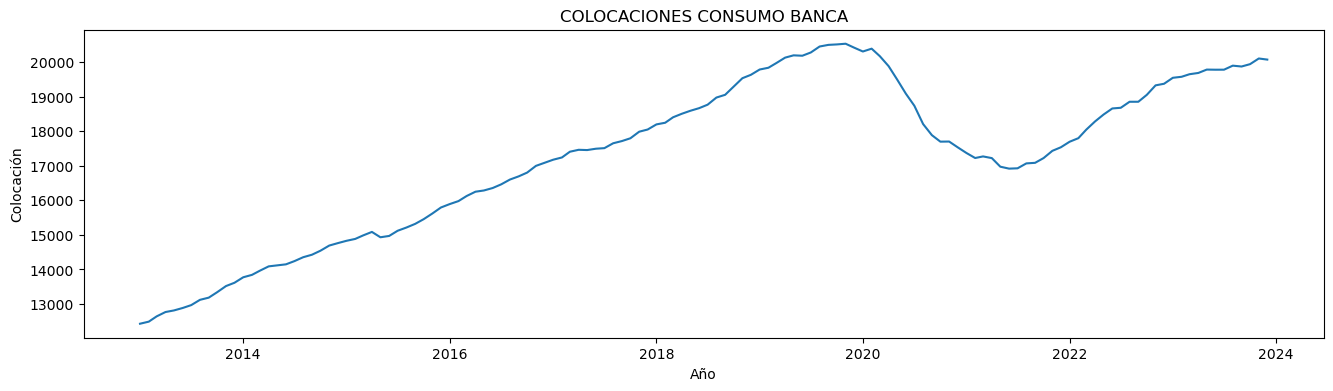

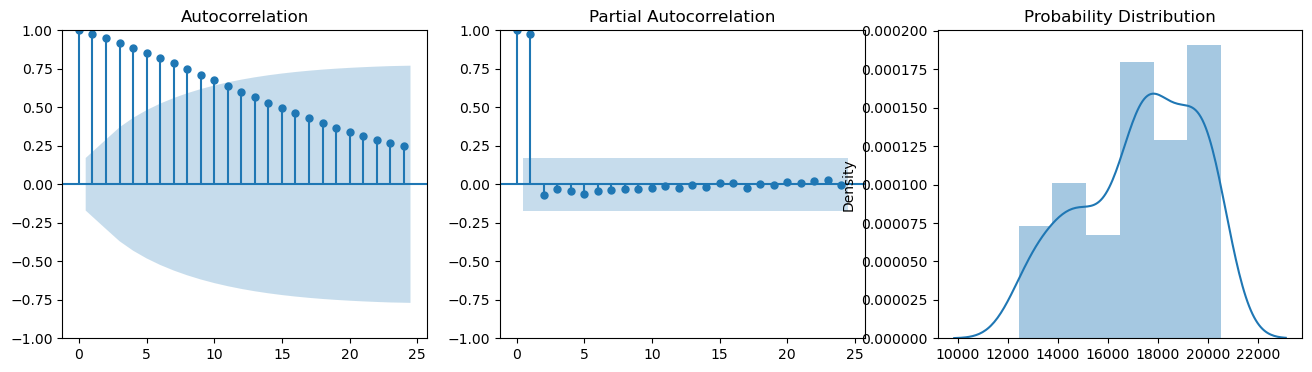

In [312]:
plot_data_properties(df_end, 'COLOCACIONES CONSUMO BANCA')

In [313]:
# test adfuller para estacionariedad
#H0: serie no es estacionaria
#H1: serie es estacionaria
def test_stationarity(data):
    p_val=adfuller(data['Consumo'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(round(p_val,4)))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(round(p_val,4)))
        
test_stationarity(df_end)

Time series data is not stationary. Adfuller test pvalue=0.4922


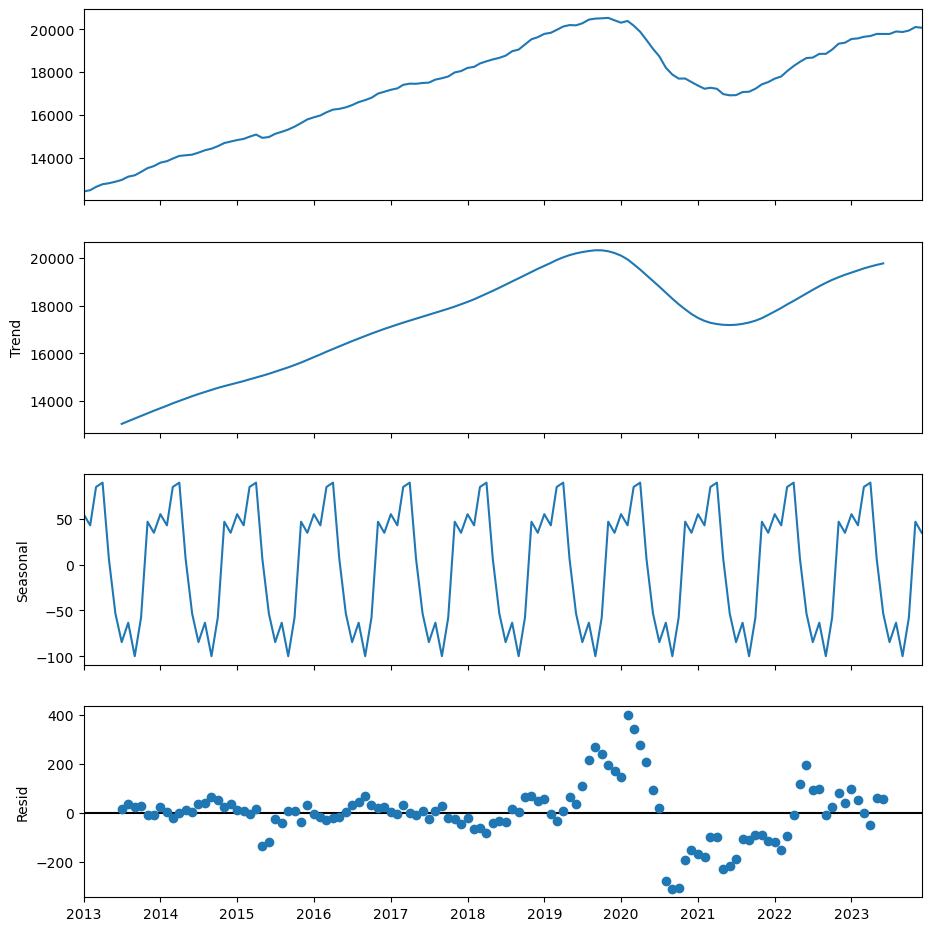

In [314]:
#descomposición de la serie
res = seasonal_decompose(df_end,model="additive")
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

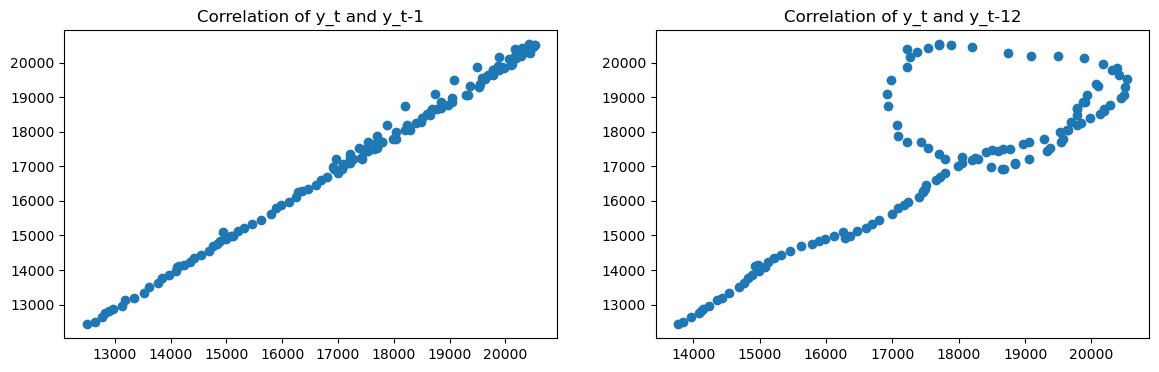

In [315]:
#correlacion Yt con Yt-1, Yt con Yt-12 
fig, axes = plt.subplots(1,2, squeeze=False);
fig.set_size_inches(14,4);
axes[0,0].scatter(x=df_end[1:], y=df_end.shift(1)[1:]);
axes[0,1].scatter(x=df_end[12:], y=df_end.shift(12)[12:]);
axes[0,0].set_title('Correlation of y_t and y_t-1');
axes[0,1].set_title('Correlation of y_t and y_t-12');

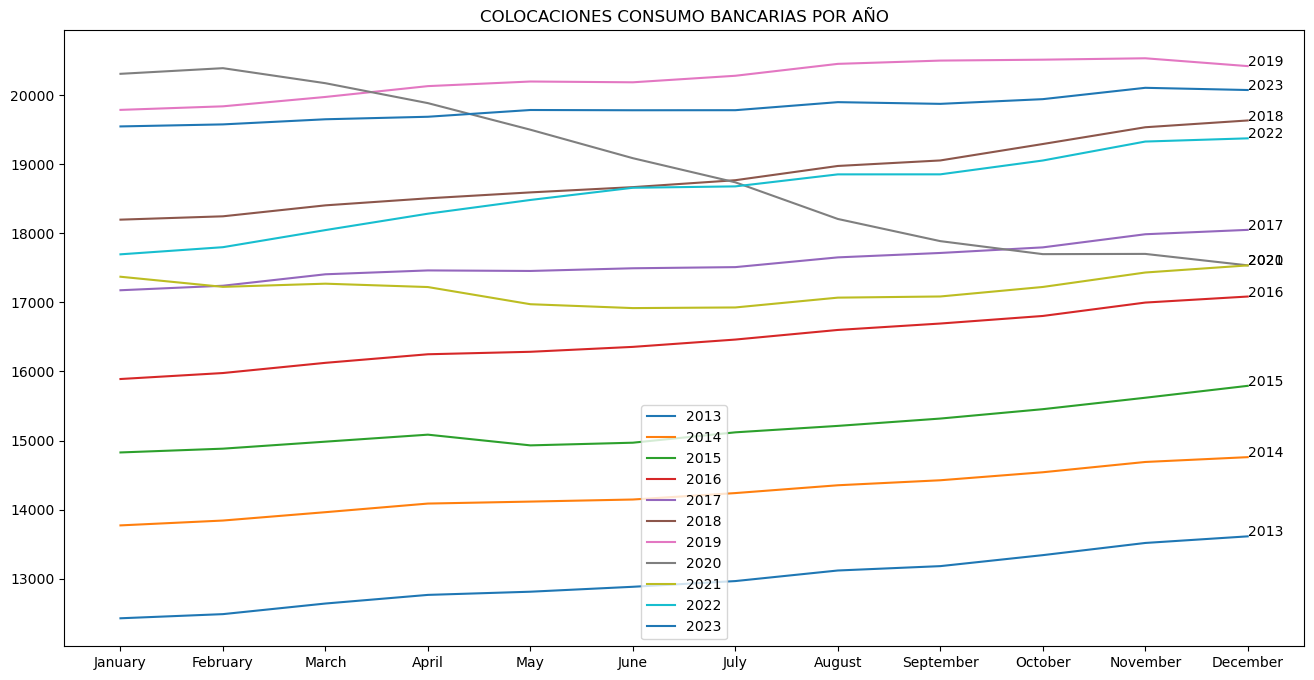

In [316]:
plt.figure(figsize=(16,8))
#plt.grid(which='both')
years = int(np.round(len(df_end)/12))
for i in range(years):
    index = df_end.index[i*12:(i+1)*12]
    plt.plot(df_end.index[:12].month_name(),df_end.loc[index].values);
    plt.text(y=df_end.loc[index].values[11], x=11, s=df_end.index.year.unique()[i]);
plt.legend(df_end.index.year.unique(), loc=0);
plt.title('COLOCACIONES CONSUMO BANCARIAS POR AÑO');

In [317]:
ini_train = '2013-01-01'
fin_train = '2022-12-01'
ini_test = '2023-01-01'
fin_test = '2023-12-01'

In [318]:
df_exo_test=df_exo.loc[ini_test:fin_test]
df_exo_train=df_exo.loc[ini_train:fin_train]
df_exo_train.columns

Index(['Desempleo', 'Imacec', 'TPM'], dtype='object')

In [319]:
df_end_test=df_end.loc[ini_test:fin_test]
df_end_train=df_end.loc[ini_train:fin_train]
df_end_train.columns

Index(['Consumo'], dtype='object')

### Entrenamiento modelo con todas las variables exogenas

#### Con AutoArima

In [320]:
len(df_end_train)

120

In [321]:
df_end_train.tail()

,Consumo
Periodo,
2022-08-01,18851.077508
2022-09-01,18851.435194
2022-10-01,19051.489502
2022-11-01,19325.749053
2022-12-01,19372.207730


In [322]:
model = pm.auto_arima(df_end_train, 
                      df_exo_train,
                      d=None, D=None,
                      trend=None, seasonal = True,m=12,
                      start_p=0, start_q=0, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1499.505, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1505.487, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1418.201, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1460.170, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1522.219, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1423.811, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1430.905, Time=0.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1413.723, Time=0.52 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1422.580, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1424.525, Time=1.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1424.682, Time=0.77 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept

In [323]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -698.862
Date:                              Tue, 25 Jun 2024   AIC                           1413.723
Time:                                      20:07:43   BIC                           1435.956
Sample:                                  01-01-2013   HQIC                          1422.752
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1556      1.208      0.129      0.898      -2.212       2.523
Desempleo    -38.0203     23.052     -1.649      0.099     -83.201       7.161
Imacec        10.1548      2.612      3.887      0.000       5.035      15.275
TPM           76.7327     39.783      1.929      0.054      -1.241     154.706
ar.L1          0.7586      0.054     13.928      0.000       0.652       0.865
ar.S.L12       0.9459      0.113      8.384      0.000       0.725       1.167
ma.S.L12      -0.8182      0.216     -3.787      0.000      -1.242      -0.395
sigma2      7097.3133   1025.319      6.922      0.000    5087.725    9106.902
===================================================================================
Ljung-Box (L1) (Q):                   4.15   Jarque-Bera (JB):                24.36
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.73   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Modelo con pm.ARIMA (se especifica el modelo)

In [324]:
df_exo.drop(['Desempleo','TPM'],axis=1,inplace=True)
df_exo_test=df_exo.loc[ini_test:fin_test]
df_exo_train=df_exo.loc[ini_train:fin_train]
df_exo_train.columns

Index(['Imacec'], dtype='object')

In [325]:
model = pm.auto_arima(df_end_train, 
                      df_exo_train,
                      d=None, D=None,
                      trend=None, seasonal = True,m=12,
                      start_p=0, start_q=0, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1514.557, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1518.996, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1413.522, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1459.694, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1536.073, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1422.867, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1415.157, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1401.940, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1414.587, Time=0.23 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1416.278, Time=0.57 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

In [326]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -694.970
Date:                              Tue, 25 Jun 2024   AIC                           1401.940
Time:                                      20:08:00   BIC                           1418.615
Sample:                                  01-01-2013   HQIC                          1408.711
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0666      0.371     -0.179      0.858      -0.795       0.661
Imacec        10.1160      2.087      4.847      0.000       6.026      14.206
ar.L1          0.8138      0.035     23.552      0.000       0.746       0.882
ar.S.L12       0.9794      0.055     17.692      0.000       0.871       1.088
ma.S.L12      -0.8741      0.178     -4.924      0.000      -1.222      -0.526
sigma2      6055.8570    844.351      7.172      0.000    4400.960    7710.754
===================================================================================
Ljung-Box (L1) (Q):                   3.16   Jarque-Bera (JB):                18.58
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               3.48   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [327]:
# Ajuste del modelo ARIMAX
#model = pm.ARIMA(
#    order=(3, 1, 0),  # Parámetros del modelo ARIMA
#    seasonal_order=(0, 0, 0, 0),  # No estacional
#    suppress_warnings=True,
#    with_intercept=False
#)
#model.fit(df_end_train, X=df_exo_train_2)

In [328]:
#print(model.summary())

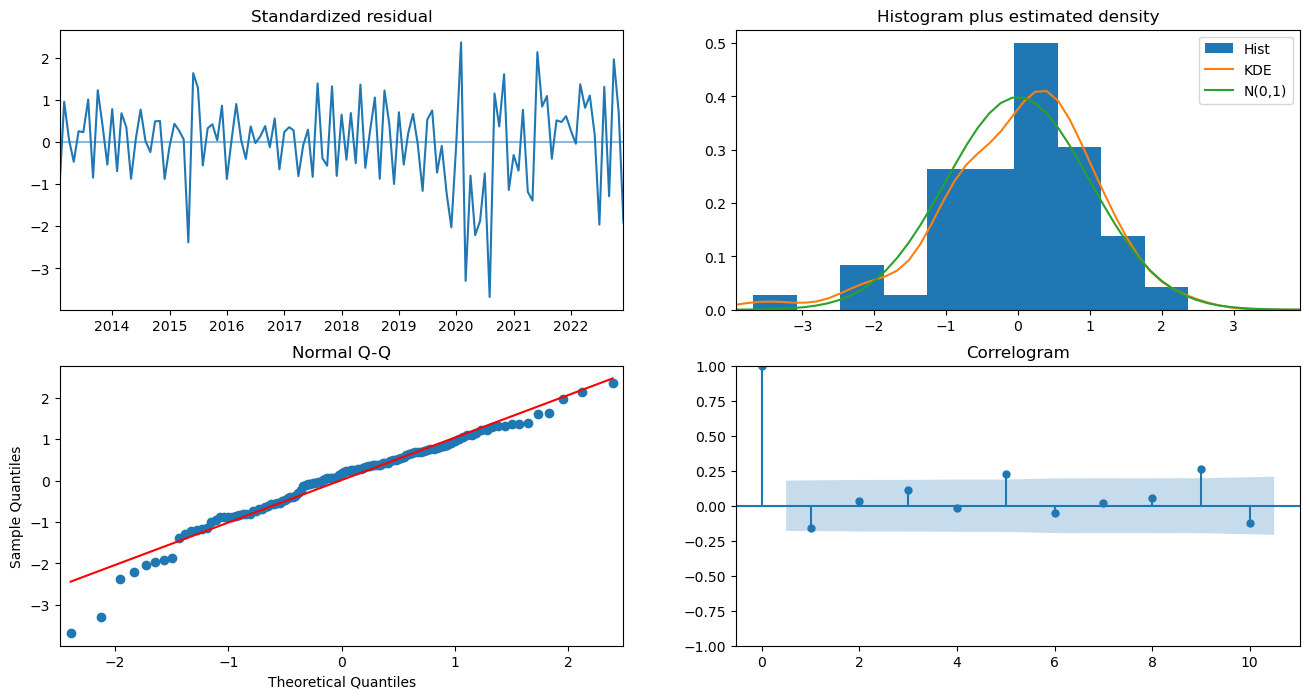

In [329]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [330]:
#df_exo_test_2.tail()
len(df_exo_train)

120

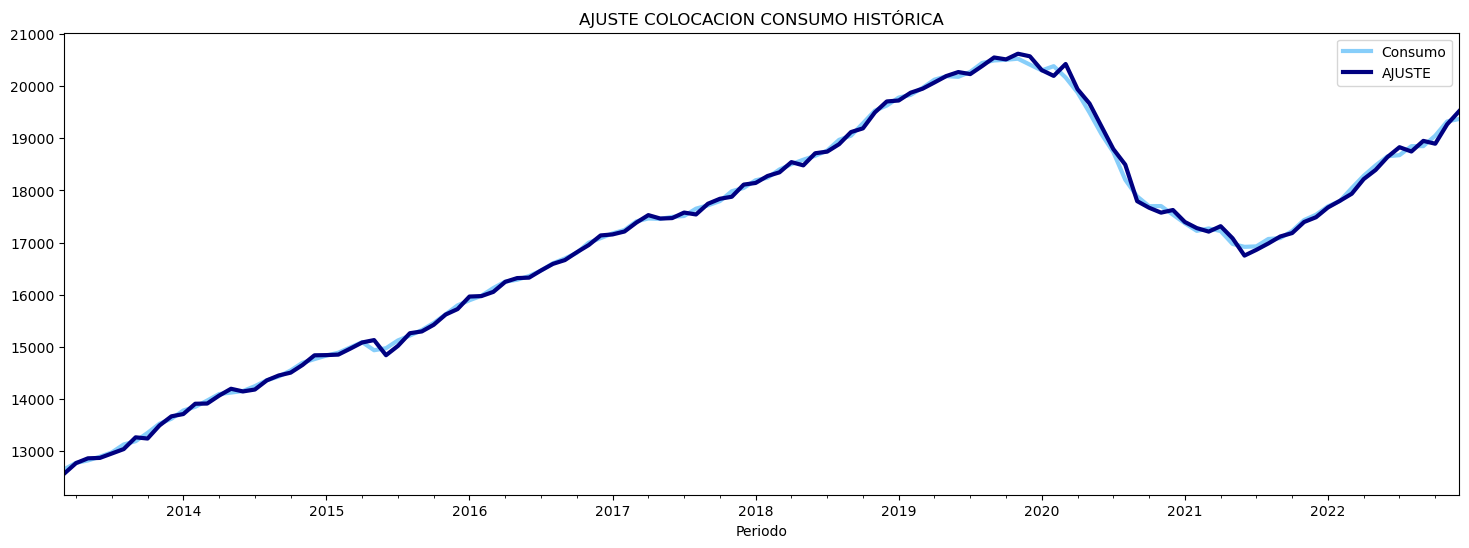

In [339]:
predictions = model.predict_in_sample(X=df_exo_train[2:120], 
                                     start=2,
                                     end=119, 
                                     dynamic=False, 
                                     return_conf_int=False, 
                                     alpha=0.05)
title = 'AJUSTE COLOCACION CONSUMO HISTÓRICA'
ax = df_end[2:120].plot(legend=True,figsize=(18,6),title=title,linewidth=3, color='#87CEFA')
predictions.plot(legend=True,linewidth=3, color='#000080',label = 'AJUSTE')
ax.autoscale(axis='x',tight=True)

In [332]:
r2_score(df_end[2:120], predictions)
evaluation_results = pd.DataFrame({'R2_Score': r2_score(df_end[2:120], predictions)}, index=[0])
evaluation_results['MAE'] = mean_absolute_error(df_end[2:120], predictions)
#evaluation_results['mean_squared_error'] = mean_squared_error(df_end[1:84], predictions)
evaluation_results['MAPE'] = np.mean(np.abs(predictions - df_end[2:120]['Consumo'])/np.abs(df_end[2:120]['Consumo']))*100 

evaluation_results

,R2_Score,MAE,MAPE
0,0.998585,63.2258,0.366788


In [333]:
#función error absoluto medio
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values) 

In [334]:
limites =pd.DataFrame(model.predict(n_periods=12, X=df_exo_test, return_conf_int=True, alpha=0.05)[1],
             columns = ['Lim_Inf','Lim_Sup'],
                index = df_exo_test.index)
media = pd.DataFrame(model.predict(n_periods=12, X=df_exo_test, return_conf_int=False, alpha=0.05),
             columns=['Media'],
                      index=df_exo_test.index)
preds= pd.concat([media,limites],axis=1)

In [335]:
#MAPE y MAE en test
print("MAPE:{}%".format(np.round(mean_abs_pct_error(df_end[120:],preds['Media']),2)))
print("MAE:{}".format(np.round(mean_absolute_error(df_end[120:],preds['Media']),2)))

MAPE:0.99%
MAE:196.03


In [336]:
#junto los valores de test con las predicciones
df_test_2022_2023=pd.concat([df_end[120:],preds],axis=1)

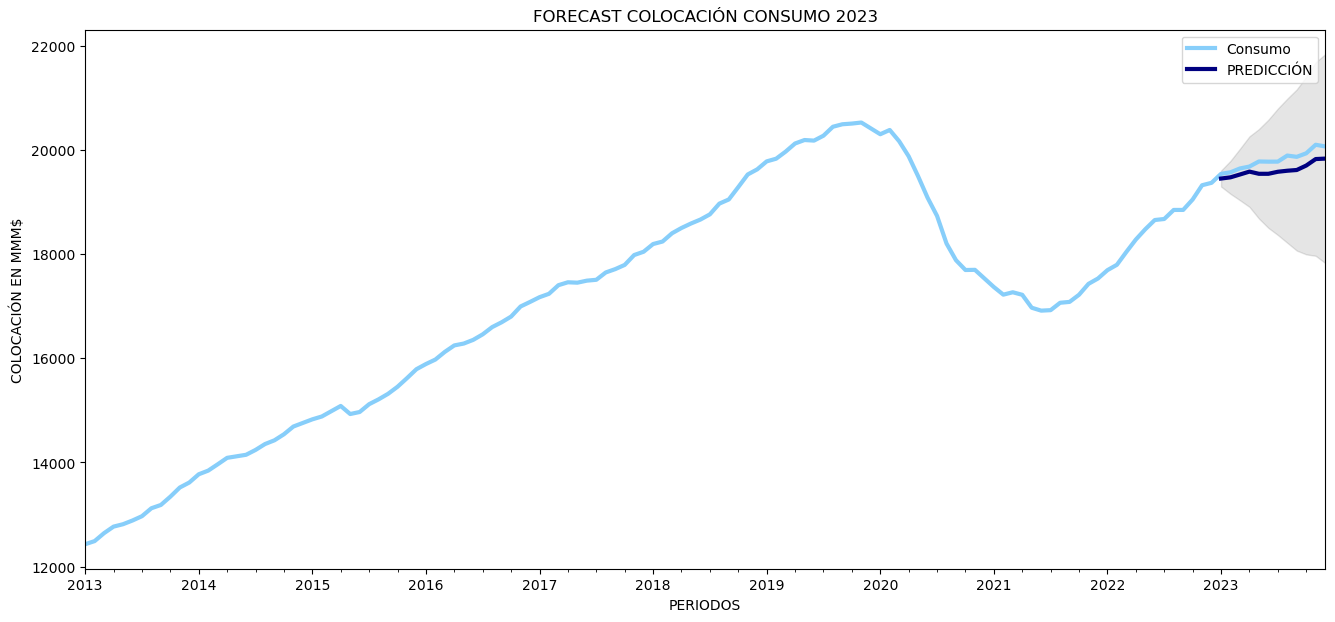

In [338]:
ax = df_end.plot(label='COLOCACIÓN', figsize=(16, 7),linewidth=3, color='#87CEFA')
df_test_2022_2023['Media'].plot(ax=ax, label='PREDICCIÓN',linewidth=3, color='#000080')
ax.fill_between(df_test_2022_2023[['Lim_Inf','Lim_Sup']].index,
                df_test_2022_2023[['Lim_Inf','Lim_Sup']].iloc[:, 0],
                df_test_2022_2023[['Lim_Inf','Lim_Sup']].iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('PERIODOS')
ax.set_ylabel('COLOCACIÓN EN MMM$')
ax.set_title('FORECAST COLOCACIÓN CONSUMO 2023')
ax.legend()
plt.show()